In [1]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

import jax.random as jr
import jax.numpy as jnp
import jax
from dynamax.hidden_markov_model import GaussianHMM, DiagonalGaussianHMM, LinearAutoregressiveHMM

import os
import glob
import h5py

In [2]:
#utils
def load_fmri(data_root, file_pattern):
    data = []
    subjects = []
    folders = sorted([
        f for f in os.listdir(data_root)
        if os.path.isdir(os.path.join(data_root, f))
    ])
    
    for folder in folders:
        matched_files = glob.glob(os.path.join(data_root, folder, file_pattern))
        if not matched_files:
            print(f"No files found matching {file_pattern} in {folder}")
            continue
            
        for file_path in matched_files:
            try:
                with h5py.File(file_path, 'r') as hdf:
                    data.append(hdf["dataset"][:])
                    subjects.append(folder)
            except Exception as e:
                print(f"Error loading {file_path}: {str(e)}")
                
    return data, subjects

def plot_signals(x, dt=1, n_plot=10, n_parcels=None, title=None, figsize=(10,5)):
    '''
    Plot the trajectory of a signal over time
    ---------------------------------------------- PARAMETERS ----------------------------------------------
    x (ndarray): 2D array (time_steps x n_parcels) representing the trajectory of the signal
    dt (float): Time step used in the simulation
    num_trajectories (int): Number of trajectories to randomly select for plotting
    time_steps (int): Total number of time steps in the simulation
    n_parcels (int): Total number of parcels in the simulation
    --------------------------------------------------------------------------------------------------------
    '''
    time_steps = x.shape[0]
    n_parcels = x.shape[1]

    # Generate the time array
    time = np.arange(0, time_steps * dt, dt)

    # Select random trajectories to plot
    random_indices = np.random.choice(n_parcels, size=n_plot, replace=False)
    selected_trajectories = x[:, random_indices]

    # Create the plot
    plt.figure(figsize=figsize)
    plt.plot(time, selected_trajectories, lw=1.5)
    plt.title(title, fontsize=14)
    plt.xlabel('Time', fontsize=13)
    plt.ylabel('x(t)', fontsize=13)
    plt.yticks([np.round(np.max(selected_trajectories), 0), 0, np.round(np.min(selected_trajectories), 0)])

    # Customize the plot
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()


def compute_pca(signal, n_components=None):
    '''
    Compute the PCA of a given signal
    ---------------------------------------------- PARAMETERS ----------------------------------------------
    - signal (ndarray): The input signal, shape (n_samples, n_features)
    - n_components (int or None): Number of principal components to keep. If None, all components are kept
    --------------------------------------------------------------------------------------------------------
    Returns:
    - pca_components (ndarray): The principal components of the signal
    - explained_variance_ratio (ndarray): The variance explained by each principal component
    '''
    # Initialize PCA
    pca = PCA(n_components=n_components)

    # Fit and transform the signal
    projections = pca.fit_transform(signal)

    # Get explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    # eigenvectors
    eigenvectors = pca.components_

    return projections, explained_variance_ratio, eigenvectors

In [7]:
# Load the data
data_root = "/home/zenari/data/fMRI_timeseries_clean_denoised_GSR_parcellated"
file_filter = "task-hammer*.h5"
data, subjects = load_fmri(data_root, file_filter)

No files found matching task-hammer*.h5 in NDAR_INVBL062HTE
No files found matching task-hammer*.h5 in NDAR_INVBY805EE5
No files found matching task-hammer*.h5 in NDAR_INVGB371PPV
No files found matching task-hammer*.h5 in NDAR_INVGT021UPR
No files found matching task-hammer*.h5 in NDAR_INVHA329EL1
No files found matching task-hammer*.h5 in NDAR_INVLL260KC0
No files found matching task-hammer*.h5 in NDAR_INVPF283TAQ
No files found matching task-hammer*.h5 in NDAR_INVRR054KAM
No files found matching task-hammer*.h5 in NDAR_INVUA181LXU
No files found matching task-hammer*.h5 in NDAR_INVVU614ZKP
No files found matching task-hammer*.h5 in NDAR_INVXR625UBQ
No files found matching task-hammer*.h5 in NDAR_INVXV404VJL
No files found matching task-hammer*.h5 in NDAR_INVYT858CBN
No files found matching task-hammer*.h5 in NDAR_INVZH090MNG
No files found matching task-hammer*.h5 in NDAR_INVZU586UPF


In [8]:
print('Number of fMRI:', len(subjects))
print('Shape of example fMRI:', data[0].shape)

Number of fMRI: 226
Shape of example fMRI: (434, 493)


In [10]:
# Filtered list containing only elements with the expected shape
expected_shape = (434, 493)


print('Initial number of fMRI:', len(data))
data_cleaned = [sub for sub in data if sub.shape == expected_shape]
print('Final number of fMRI:', len(data_cleaned))

Initial number of fMRI: 226
Final number of fMRI: 219


In [11]:
#Subsampling the data
n = 219 #number of fMRI
n_sample = np.random.randint(0, len(data_cleaned), n)

data_sub = [data_cleaned[i] for i in n_sample]

data_sub = np.array(data_sub)

data_sub.shape

(219, 434, 493)

In [81]:
#Zscore the data
data_zsc = np.array([
        (bold_sub - np.mean(bold_sub, axis=1, keepdims=True)) / np.std(bold_sub, axis=1, keepdims=True)
        for bold_sub in data_sub
    ])    

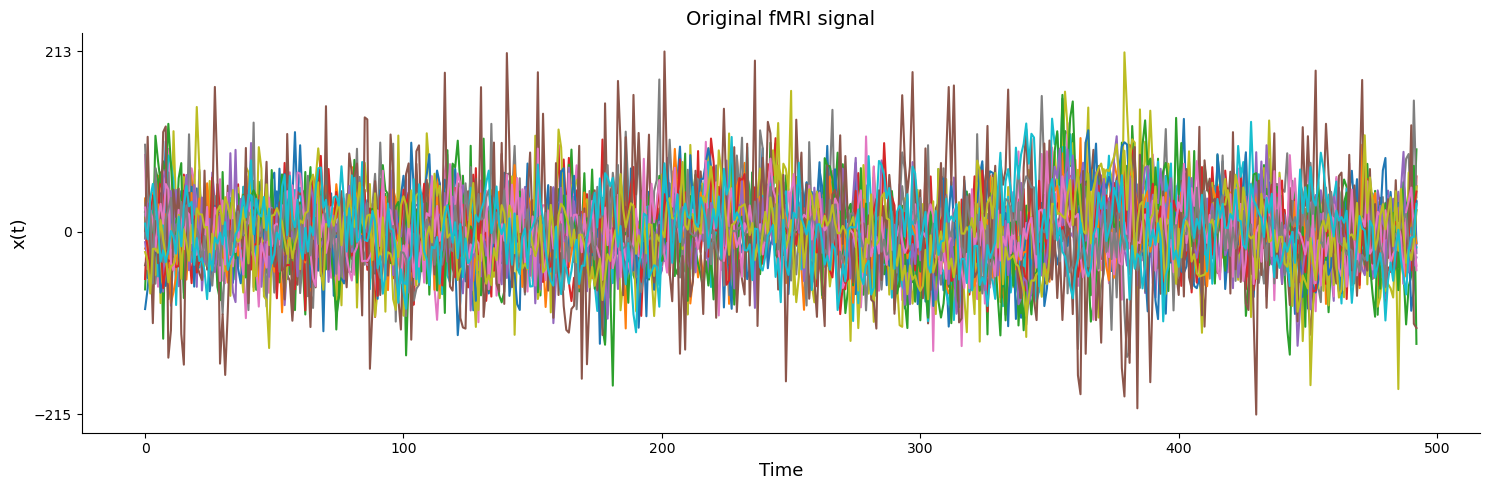

In [82]:
#plotting original sample
k = np.random.randint(0, n)
plot_signals(data_sub[k].T, dt = 1, n_plot=20, n_parcels=data_sub[k].shape[1], title='Original fMRI signal', figsize=(15, 5))

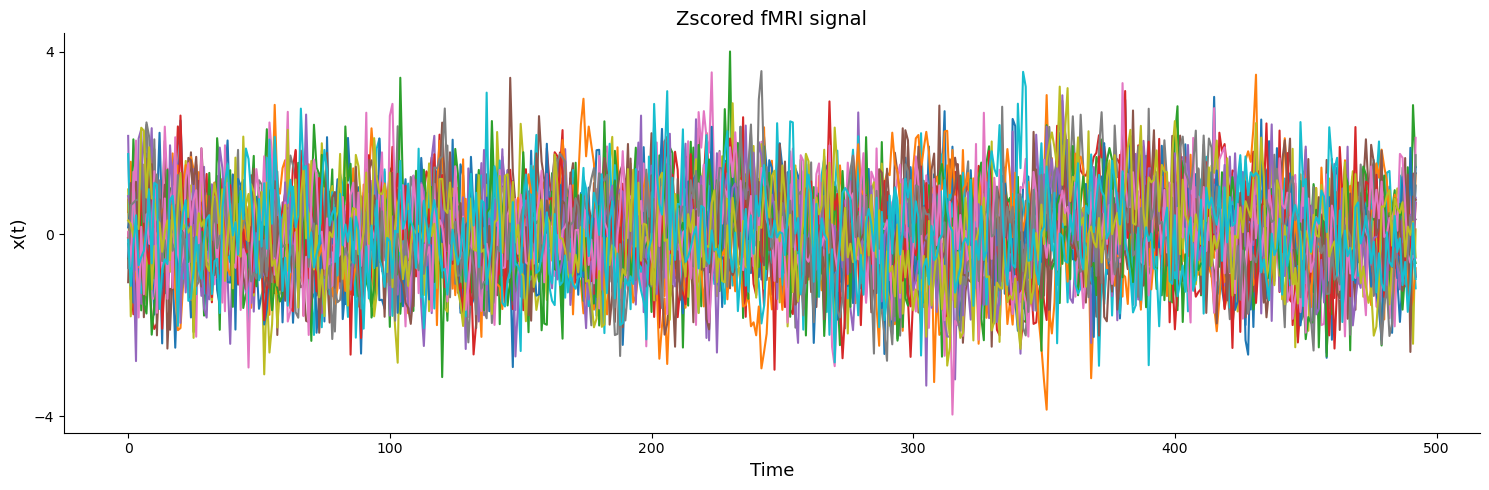

In [83]:
#plotting zscored sample  
plot_signals(data_zsc[k].T, dt = 1, n_plot=20, n_parcels=data_zsc[k].shape[1], title='Zscored fMRI signal', figsize=(15, 5))

In [15]:
print('Shape of the data:', data_zsc.shape)

n_subject = data_zsc.shape[0]
n_parcels = data_zsc.shape[1]
n_time = data_zsc.shape[2]

print('Number of subjects:', n_subject)
print('Number of parcels:', n_parcels)
print('Number of time points:', n_time)

Shape of the data: (219, 434, 493)
Number of subjects: 219
Number of parcels: 434
Number of time points: 493


In [16]:
### concatenating the data
x = data_zsc.transpose(1, 0, 2).reshape(n_parcels, n_time * n_subject)
print('Shape of the concatenated data:', x.shape)

Shape of the concatenated data: (434, 107967)


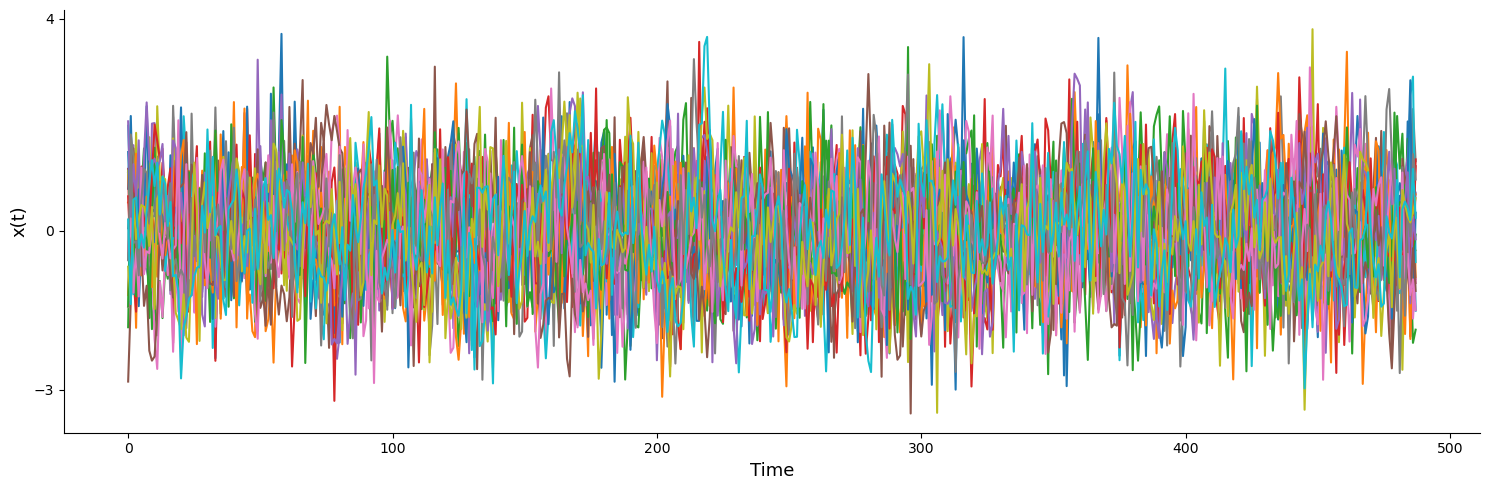

In [17]:
plot_signals(x[:, :488].T, dt = 1, n_plot=20, n_parcels=20, figsize=(15, 5))

In [18]:
#checking for Nan
np.isnan(x).any()

False

### PCA

In [19]:
projections, explained_variance_ratio, eigenvectors = compute_pca(x.T, n_parcels)

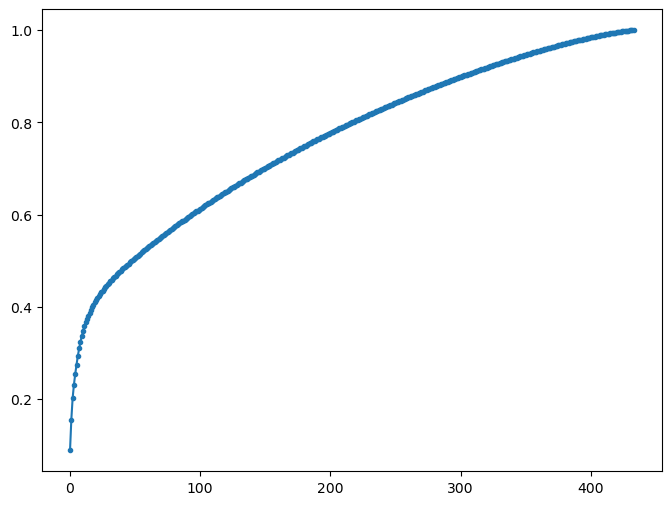

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_ratio), '.-')
plt.show()

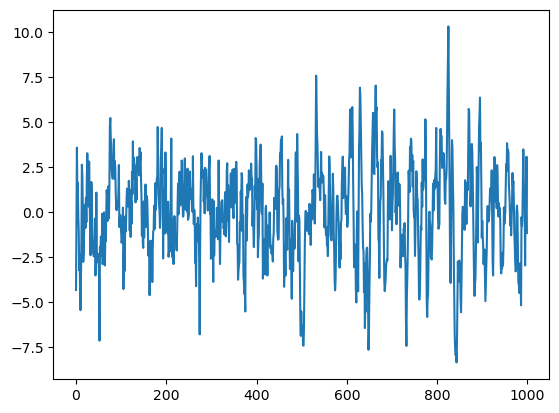

In [91]:
#plotting the time-series of the first pca
plt.plot(projections[:1000, 5])
plt.show()

### Number of parameter to estimates

In [24]:
def num_params_gaussian_hmm(K, D):
    init_probs = K - 1
    transitions = K * (K - 1)
    means = K * D
    covs = K * (D * (D + 1)) // 2
    return init_probs + transitions + means + covs

def num_params_ar_hmm(K, D, P=1):
    init_probs = K - 1
    transitions = K * (K - 1)
    ar_weights = K * D * D * P  # P lags
    biases = K * D
    covs = K * (D * (D + 1)) // 2
    return init_probs + transitions + ar_weights + biases + covs

def num_params_lgssm(D, n):
    # State dynamics
    A = n * n
    Q = (n * (n + 1)) // 2
    # Emission
    C = D * n
    R = (D * (D + 1)) // 2
    # Initial state
    mu0 = n
    Sigma0 = (n * (n + 1)) // 2
    return A + Q + C + R + mu0 + Sigma0

# Example usage:
K = 4   # Number of discrete states
D = 20   # Observation dimension
P = 1   # AR order
n = 3   # Latent state dimension

print("Gaussian HMM params:", num_params_gaussian_hmm(K, D))
print("AR-HMM params:      ", num_params_ar_hmm(K, D, P))
print("LGSSM params:       ", num_params_lgssm(D, n))


Gaussian HMM params: 935
AR-HMM params:       2535
LGSSM params:        294


### HMM parameters

In [106]:
#hyperparameters
n_components = 20
print('Expalined variance considered:', np.cumsum(explained_variance_ratio)[n_components-1])
n_states = 4

Expalined variance considered: 0.409078784886039


## HMM - Lineare Autoregression

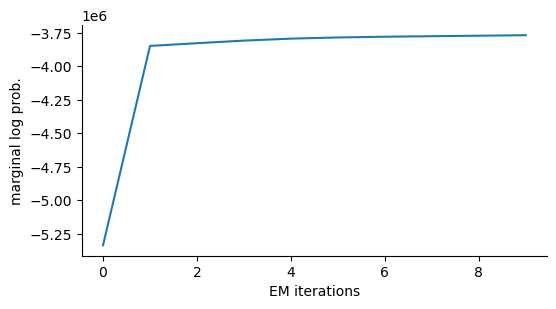

<Figure size 640x480 with 0 Axes>

In [109]:
emissions = projections[:, :n_components]
emissions_dim = emissions.shape[1]


hmm = LinearAutoregressiveHMM(n_states, emissions_dim, num_lags=10)

### Fit it with EM
params, props = hmm.initialize(emissions=emissions)

inputs = hmm.compute_inputs(emissions)

#params, props = hmm.initialize(emissions=emissions)
params, lls = hmm.fit_em(params, props, emissions, num_iters=10, inputs = inputs)


# Plot the marginal log probs across EM iterations
plt.figure(figsize=(6,3))
plt.plot(lls)
plt.xlabel("EM iterations")
plt.ylabel("marginal log prob.")
sns.despine()
plt.show()


post = hmm.smoother(params, emissions, inputs= inputs)

plt.tight_layout()

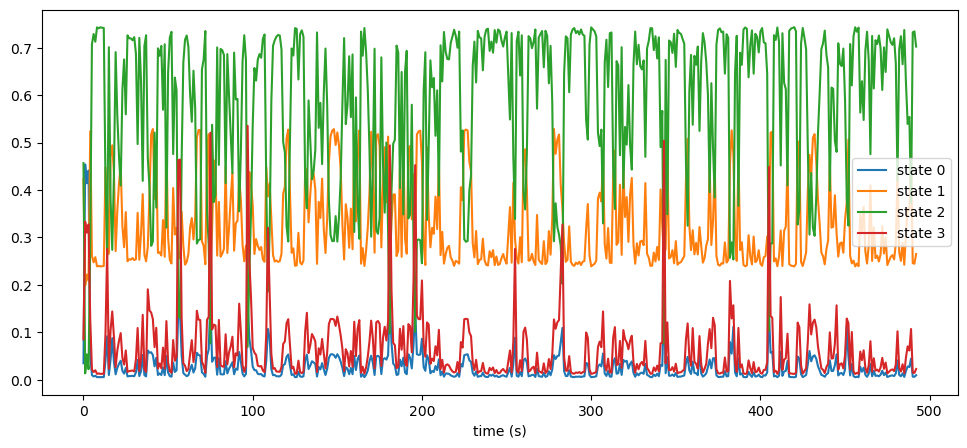

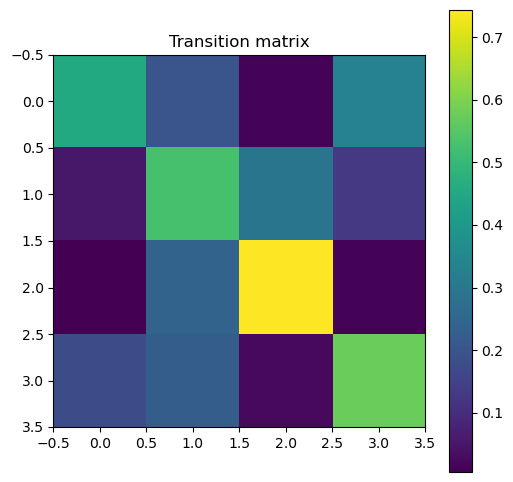

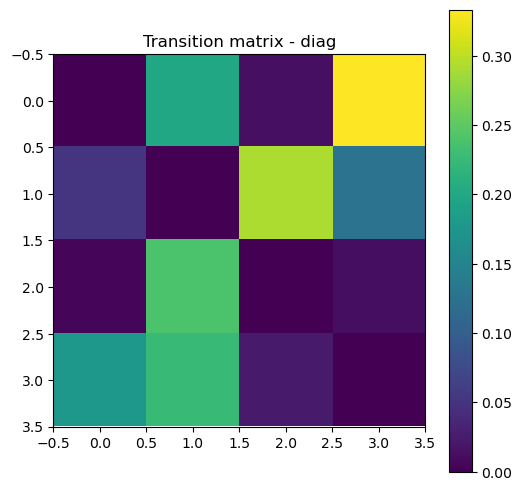

Text(0.5, 0, 'time')

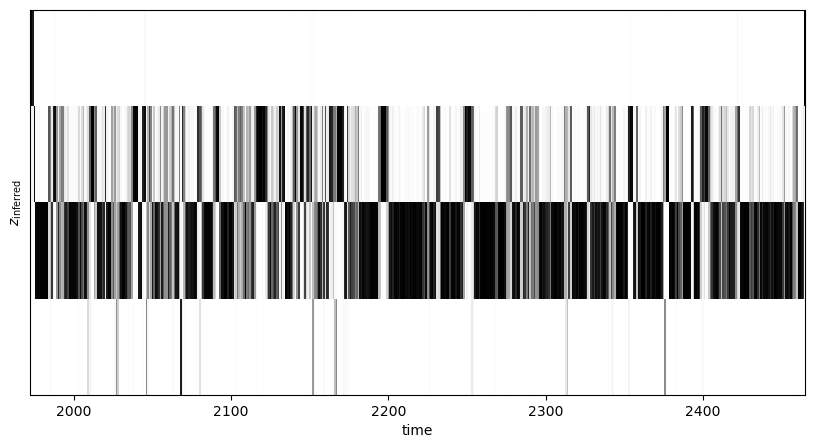

In [111]:
subj = 5

plt.figure(figsize=(26, 5))
plt.subplot(1,2,1)
for k in range(n_states): plt.plot(np.arange(n_time), post.predicted_probs[n_time*(subj-1):n_time*subj, k], label=f'state {k}')
plt.xlabel('time (s)')
plt.legend()


plt.figure(figsize=(6,6))
#plt.imshow(np.log(np.array(params.transitions).squeeze()))
plt.imshow(np.array(params.transitions).squeeze())
plt.colorbar()
plt.title('Transition matrix')
plt.show()


params_trans = np.array(params.transitions).squeeze()
plt.figure(figsize=(6,6))
#plt.imshow(np.log(np.array(params.transitions).squeeze()))
plt.imshow(params_trans - np.diag(np.diag(params_trans)))
plt.colorbar()
plt.title('Transition matrix - diag')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(post.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(n_time*(subj-1),n_time*subj)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")


### Gaussian HMM

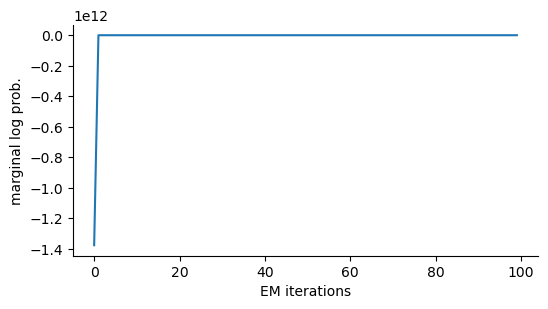

<Figure size 640x480 with 0 Axes>

In [112]:
emissions = projections[:, :n_components]
emissions_dim = emissions.shape[1]


hmm = GaussianHMM(n_states, emissions_dim)

### Fit it with EM
params, props = hmm.initialize(emissions=emissions)


#params, props = hmm.initialize(emissions=emissions)
params, lls = hmm.fit_em(params, props, emissions, num_iters=100)


# Plot the marginal log probs across EM iterations
plt.figure(figsize=(6,3))
plt.plot(lls)
plt.xlabel("EM iterations")
plt.ylabel("marginal log prob.")
sns.despine()
plt.show()


post = hmm.smoother(params, emissions)

plt.tight_layout()

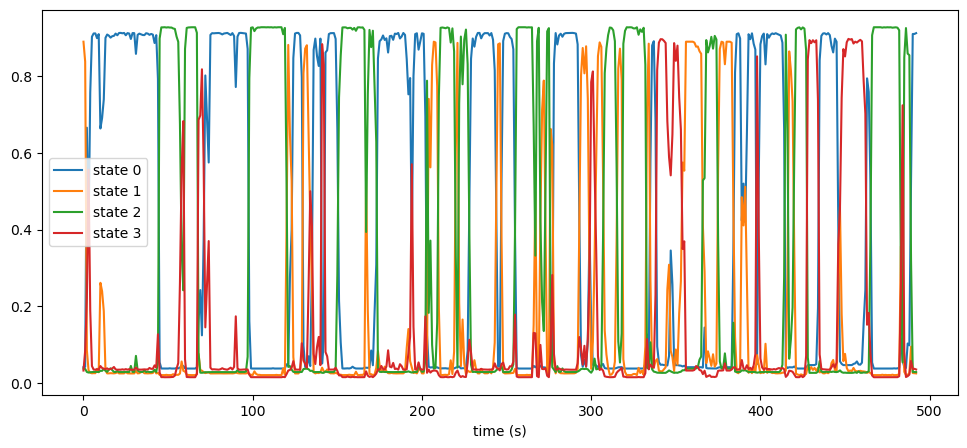

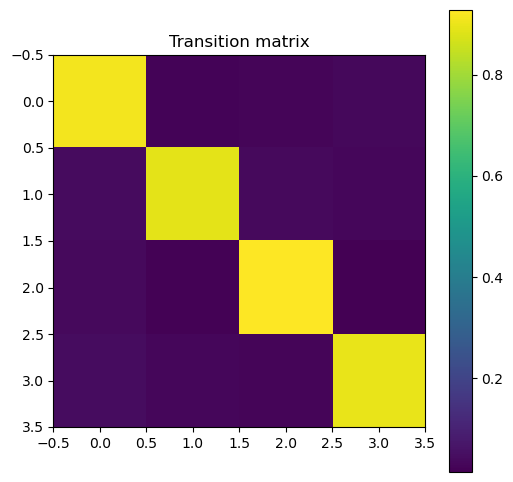

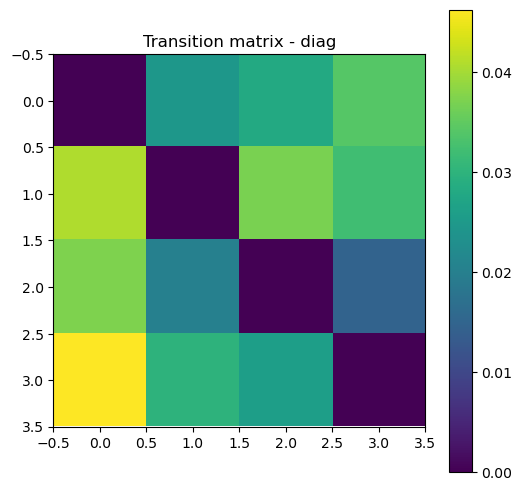

Text(0.5, 0, 'time')

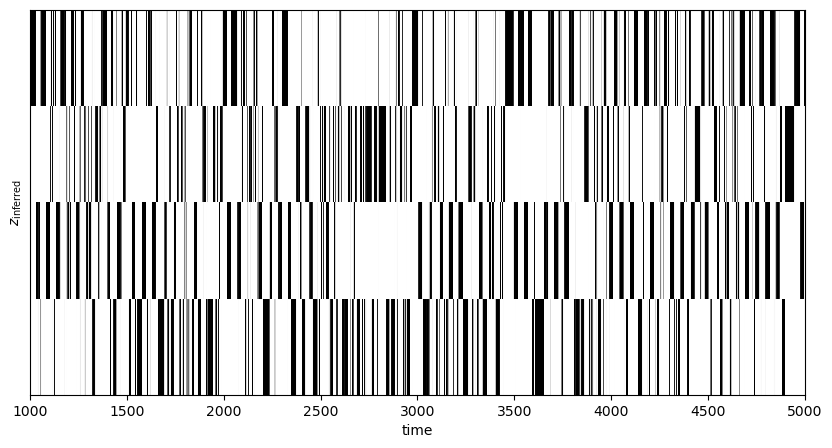

In [113]:
subj = 3

plt.figure(figsize=(26, 5))
plt.subplot(1,2,1)
for k in range(n_states): plt.plot(np.arange(n_time), post.predicted_probs[n_time*(subj-1):n_time*subj, k], label=f'state {k}')
plt.xlabel('time (s)')
plt.legend()


plt.figure(figsize=(6,6))
#plt.imshow(np.log(np.array(params.transitions).squeeze()))
plt.imshow(np.array(params.transitions).squeeze())
plt.colorbar()
plt.title('Transition matrix')
plt.show()


params_trans = np.array(params.transitions).squeeze()
plt.figure(figsize=(6,6))
#plt.imshow(np.log(np.array(params.transitions).squeeze()))
plt.imshow(params_trans - np.diag(np.diag(params_trans)))
plt.colorbar()
plt.title('Transition matrix - diag')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(post.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(1000, 5000)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

### HMM - DiagonalGaussian

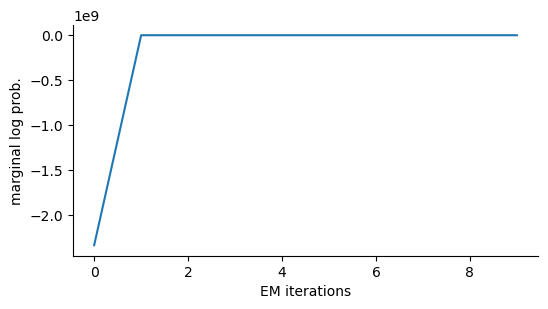

<Figure size 640x480 with 0 Axes>

In [431]:
emissions = projections[:, :n_components]
emissions_dim = emissions.shape[1]

hmm = DiagonalGaussianHMM(n_states, emissions_dim)

### Fit it with EM
params, props = hmm.initialize(emissions=emissions)


#params, props = hmm.initialize(emissions=emissions)
params, lls = hmm.fit_em(params, props, emissions, num_iters=10)


# Plot the marginal log probs across EM iterations
plt.figure(figsize=(6,3))
plt.plot(lls)
plt.xlabel("EM iterations")
plt.ylabel("marginal log prob.")
sns.despine()
plt.show()


post = hmm.smoother(params, emissions)

plt.tight_layout()

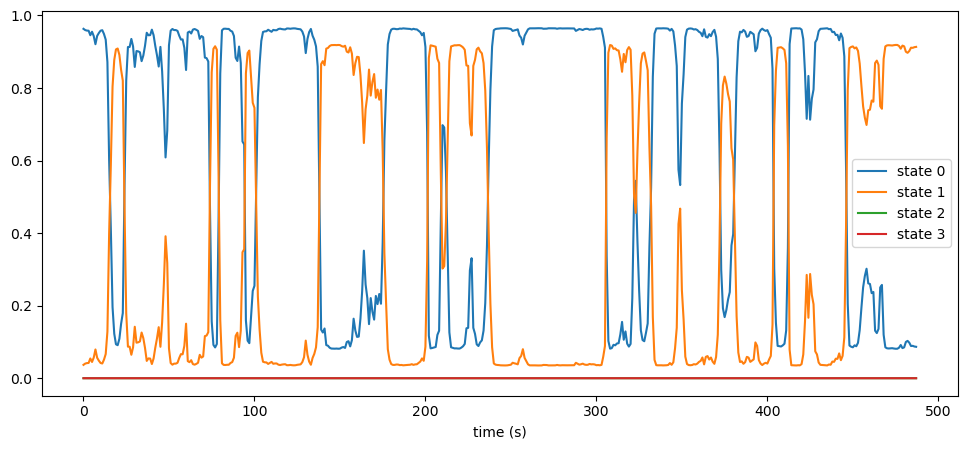

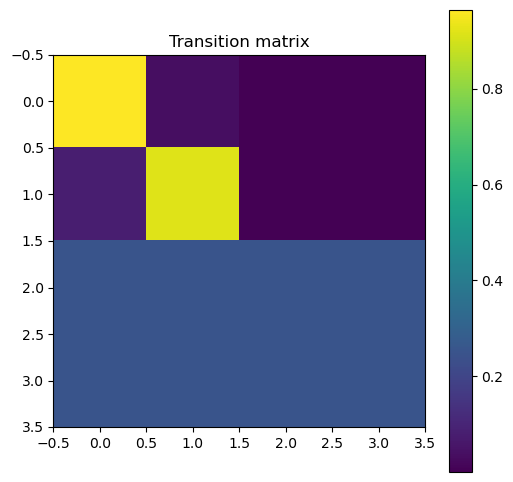

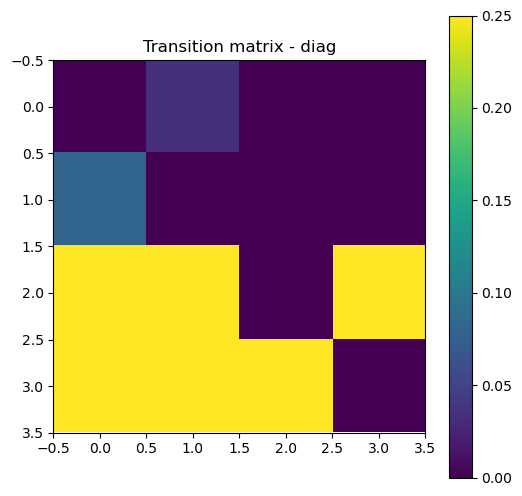

Text(0.5, 0, 'time')

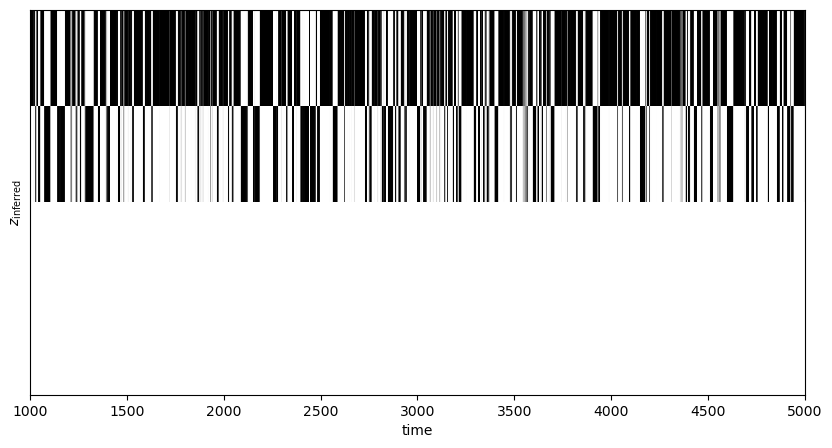

In [433]:
subj = 5

plt.figure(figsize=(26, 5))
plt.subplot(1,2,1)
for k in range(n_states): plt.plot(np.arange(n_time), post.predicted_probs[n_time*(subj-1):n_time*subj, k], label=f'state {k}')
plt.xlabel('time (s)')
plt.legend()


plt.figure(figsize=(6,6))
#plt.imshow(np.log(np.array(params.transitions).squeeze()))
plt.imshow(np.array(params.transitions).squeeze())
plt.colorbar()
plt.title('Transition matrix')
plt.show()


params_trans = np.array(params.transitions).squeeze()
plt.figure(figsize=(6,6))
#plt.imshow(np.log(np.array(params.transitions).squeeze()))
plt.imshow(params_trans - np.diag(np.diag(params_trans)))
plt.colorbar()
plt.title('Transition matrix - diag')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(post.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(1000, 5000)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

## Interpreting the states

In [114]:
means = params.emissions.means
covs = params.emissions.covs

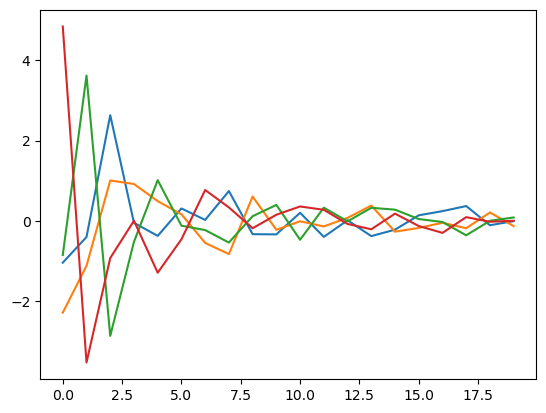

In [115]:
plt.plot(means.T)

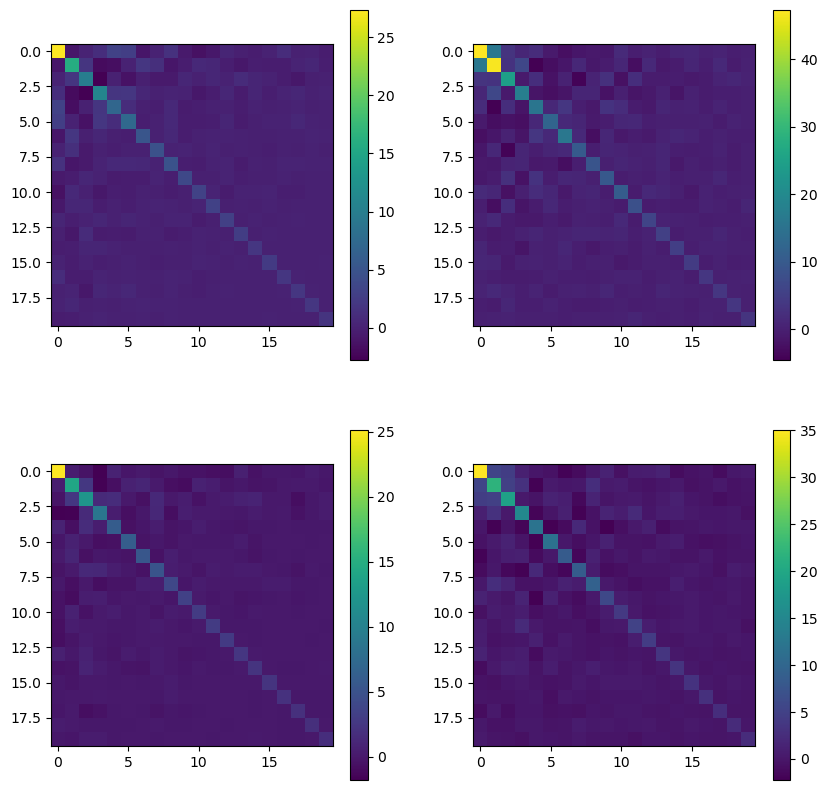

In [116]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
im1 = ax[0, 0].imshow(covs[0])
ax[0, 0].figure.colorbar(im1, ax=ax[0, 0])
im2 = ax[0, 1].imshow(covs[1])
ax[0, 1].figure.colorbar(im2, ax=ax[0, 1])
im3 = ax[1, 0].imshow(covs[2])
ax[1, 0].figure.colorbar(im3, ax=ax[1, 0])
im4 = ax[1, 1].imshow(covs[3])
ax[1, 1].figure.colorbar(im4, ax=ax[1, 1])


In [117]:
post_probs = post.predicted_probs

print(post_probs.shape)

(107967, 4)


In [118]:
occupied_state = np.argmax(post_probs, axis = 1)
occupied_state.shape

(107967,)

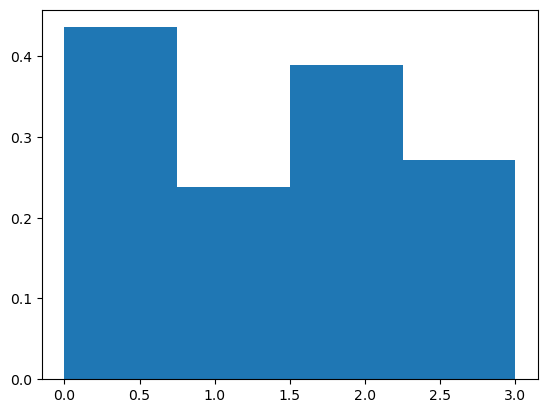

In [119]:
#frequency of occupancy
plt.hist(occupied_state, bins = 4, density = True)
plt.show()

In [131]:
from itertools import groupby

def find_runs(arr):
    runs = []
    start = 0
    for value, group in groupby(arr):
        length = len(list(group))
        end = start + length
        runs.append((value, end-start))  # (valore, inizio, fine)
        start = end
    return runs

arr = [2, 2, 3, 3, 3, 1, 1, 2, 2, 2, 2]
runs = find_runs(occupied_state)

Array(1, dtype=int32)

In [ ]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, 2)

# Plot your data on subplots

# Add colorbars to subplots
cbar1 = fig.colorbar(im1, ax=axs[0, 0])
cbar2 = fig.colorbar(im2, ax=axs[0, 1])
cbar3 = fig.colorbar(im3, ax=axs[1, 0])
cbar4 = fig.colorbar(im4, ax=axs[1, 1])

# Show the plot
plt.show()


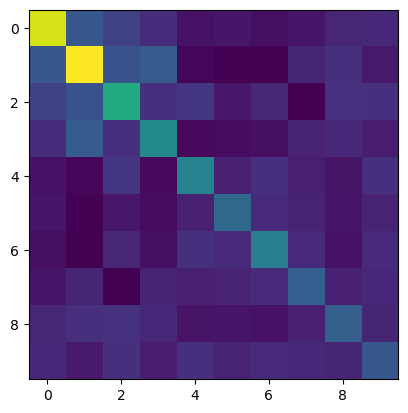

In [46]:
plt.imshow(covs[0])

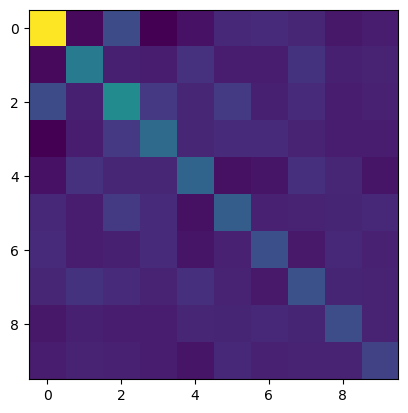

In [47]:
plt.imshow(covs[1])

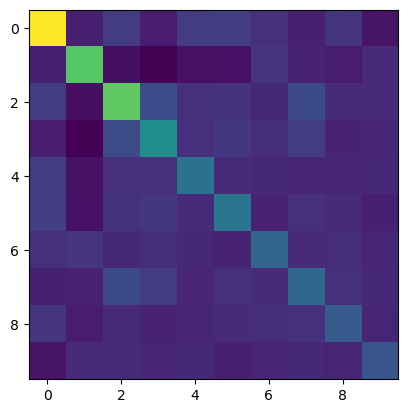

In [49]:
plt.imshow(covs[2])

In [ ]:
plt.imshow(covs[3])

In [440]:
# Initialize PCA
pca = PCA(n_components=n_components)

# Fit and transform the signal
projections = pca.fit_transform(x)

# Get explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# eigenvectors
eigenvectors = pca.components_

In [441]:
### Transform states from pc to original space
means = params.emissions.means
covs = params.emissions.covs

print(means.shape, covs.shape)

means_orig = pca.inverse_transform(params.emissions.means)
cov_orig = np.stack( [pca.components_.T @ tmp_cov @ pca.components_ for tmp_cov in covs] )
print(means_orig.shape, cov_orig.shape)

#np.save(folder_results+f'mean_n_{num_states}_comp_{n_components}.npy', means_orig)
#np.save(folder_results+f'cov_n_{num_states}_comp_{n_components}.npy', cov_orig)

(4, 10) (4, 10, 10)


(4, 48800) (4, 48800, 48800)


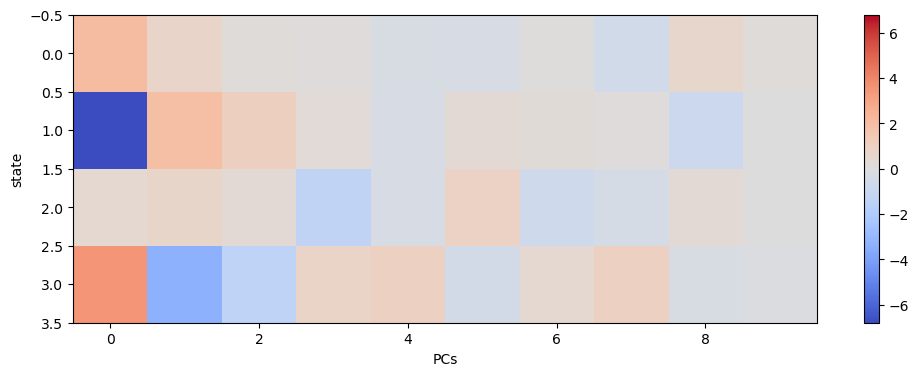

In [443]:
vmax = np.abs(means).max()
vmin = -vmax
plt.figure(figsize=(12,4))
plt.imshow(means, aspect='auto', vmin=vmin, vmax=vmax, cmap='coolwarm')
plt.colorbar()
plt.ylabel('state')
plt.xlabel('PCs')
plt.show()

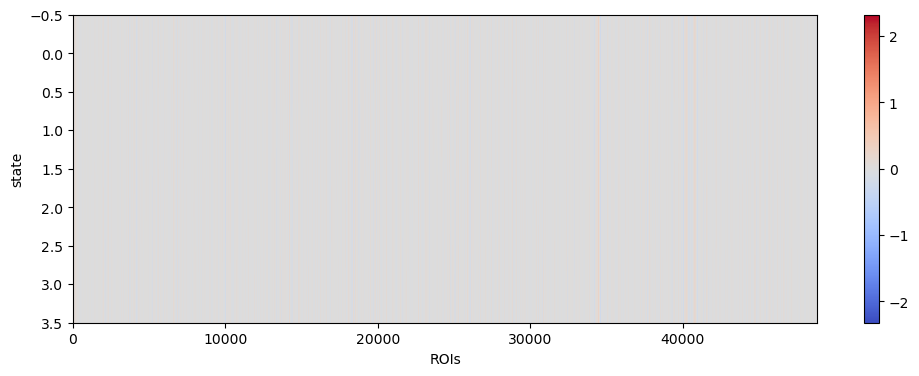

In [444]:
vmax = np.abs(means_orig).max()
vmin = -vmax
plt.figure(figsize=(12,4))
plt.imshow(means_orig, aspect='auto', vmin=vmin, vmax=vmax, cmap='coolwarm')
plt.colorbar()
plt.ylabel('state')
plt.xlabel('ROIs')
plt.show()